## Part 1: Decision Trees With Grid Search

Look at the sklearn [DecisionTreeClassifier documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html). For each hyperparameter:

* Decide if it will impact the results or exclusively impact the computational speed.
    * **Only the `ccp_alpha` value exclusively impacts computational speed.**
    * However, some values don't always make sense...
    * For example, you'll only want to use `class_weight` unless you have imbalanced classes in your dataset [(learn more here)](https://machinelearningmastery.com/cost-sensitive-decision-trees-for-imbalanced-classification/)
* Pick at least 3 values for each hyperparameter that you'd like to include in your grid search.
    * If there are fewer than 3 valid choices, include all valid choices.
    * Carefully consider the choices, try to predict the impact of this hyperparameter on the outcome. 
    * Does this hyperparameter interact with others?
    
See my choices of values below. 


**criterion** {“gini”, “entropy”}, default=”gini”

> Typically you'll end up with similar results using either of these. Gini is a bit faster to compute than entropy. Gini is a measure of "purity" while entropy is a measure of information/randomness. With Gini we are saying we want to maximize each split for homogeniety, with entropy we are maximizing the amount of "information gained" by performing the split in terms of reducing the randomness in the node. [Read more](https://towardsdatascience.com/gini-index-vs-information-entropy-7a7e4fed3fcb)

**splitter** {“best”, “random”}, default=”best”

> Best is most commonly used, and what almost everyone means when they describe a decision tree (including the lesson that this homework is based on...). Random will select still look at evrey feature but randomly select one split point per feature, then choose the best feature. I don't suggest it TBH — if you want to do something like this use a random forest instead. Using random will potentially avoid overfitting, but it will likely also decrease performance overall. 

**max_depth** int, default=None

> The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples. Shallow trees won't overfit as much, but at the risk of underfitting. Very shallow trees will only be allowed a few splits, whereas deeper trees will be allowed more. As the number of classess increases you may wish to increase the max_depth to allow your tree enough capacity to split out the classes. For example, if you have 10 classes, but a max depth of 3 (root->mid->leaf) then you'll have 4 leaf nodes, representing only 4 out of your possible 10 classes.


**min_samples_split** int or float, default=2

> The minimum number of samples required to split an internal node. Larger numbers here will smooth out the model by forcing your leaf nodes to represent a larger sub-sample of the data. This is especially true in regresssion trees, since you'll use the mean of that sub-sample as your prediction. However, as a consequence, with large numbers you might end up with "impure" leaf nodes that really ought to be split further. 

        
**min_weight_fraction_leaf** float, default=0.0

> The minimum weighted fraction of the sum total of weights (of all the input samples) required to be at a leaf node. Samples have equal weight when sample_weight is not provided. This is similar to min_samples_split but more useful when you have imbalanced classes and are using class_weight.


**max_features** int, float or {“auto”, “sqrt”, “log2”}, default=None

> Artificially limit the number of features that can be considered at each split point. If you choose a value less than the number of features available that number of features will be randomly sampled per split. This is very common in random forests, and in a single decision tree it CAN have a regularizing effect but I don't generally recommend it.  This will also speed up the computational time by reduing the overall search space.


**random_state** int, RandomState instance, default=None

> This can impact the model when there are ties for best split, or when you're using random feature selection / max_features. For deterministic results, use it. If you don't need totally deterministic results, you can ignore it. 


**max_leaf_nodes** int, default=None

> Grow a tree with max_leaf_nodes in best-first fashion. Best nodes are defined as relative reduction in impurity. If None then unlimited number of leaf nodes. An alternative way to perform regularization / stop the model from overfitting. Different from others above because it will cause the tree to grow "best split first" rather than just building the tree layer by layer. 

        
**min_impurity_decrease** float, default=0.0

> A node will be split if this split induces a decrease of the impurity greater than or equal to this value. If splitting a node can't improve our metric (gini/entropy) by at least this much then a node won't be split. This will help us avoid overfitting, and it will smooth out our model somewhat, similar to min_samples_split.


**class_weight** dict, list of dict or “balanced”, default=None

> Weights associated with classes in the form {class_label: weight}. If None, all classes are supposed to have weight one. For multi-output problems, a list of dicts can be provided in the same order as the columns of y. See this link for more: 

**ccp_alpha** non-negative float, default=0.0

> Complexity parameter used for Minimal Cost-Complexity Pruning. The subtree with the largest cost complexity that is smaller than ccp_alpha will be chosen. By default, no pruning is performed. See Minimal Cost-Complexity Pruning [(learn more here)](https://machinelearningmastery.com/cost-sensitive-decision-trees-for-imbalanced-classification/)


In [2]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV


# Load the data
heart_dataset = pd.read_csv('../datasets/uci-heart-disease/heart.csv')

# Split the data into input and labels
labels = heart_dataset['target']
input_data = heart_dataset.drop(columns=['target'])

# Note, we don't split the data. GridSearchCV will automatically apply 5-fold cross validation by default.


# Note, leaving out class_weights because our data is pretty balanced. 
tuned_parameters = {
    'criterion': ['gini', 'entropy'], # Very hard to say.
    'splitter': ['best', 'random'], # best will be best usually, but sometimes random can surprise you. 
    'max_depth': [None, 5, 10], # None is probably best, allow the tree to grow as much as it needs
    'min_samples_split': [2, 10, 30], # 2 gives the model the most power to overfit, but I think it will win.
    'max_features':[None, 'sqrt', 'log2'], # Hard to say, sqrt and log2 are very similar at this number of columns.
    'max_leaf_nodes': [None, 4, 20], # I suspect 4 will be quite bad, and None will win
    'min_impurity_decrease': [0, 0.01, .05, 0.1] # 0 or .01 will likely be best
}

# These two lines will result in every possible combo of the above paramters to be fit and scored
# which can take a LONG TIME with large datasets.
clf = DecisionTreeClassifier()
grid_tree = GridSearchCV(clf, tuned_parameters)
grid_tree.fit(input_data, labels) 

print("Best parameters set found on development set:")
print()
print(grid_tree.best_params_, grid_tree.best_score_)
print()
print("Grid scores on development set:")
print()
means = grid_tree.cv_results_['mean_test_score']
stds = grid_tree.cv_results_['std_test_score']



for mean, std, params in zip(means, stds, grid_tree.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

Best parameters set found on development set:

{'criterion': 'gini', 'max_depth': 5, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.01, 'min_samples_split': 30, 'splitter': 'random'} 0.8118032786885246

Grid scores on development set:

0.752 (+/-0.103) for {'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0, 'min_samples_split': 2, 'splitter': 'best'}
0.765 (+/-0.124) for {'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0, 'min_samples_split': 2, 'splitter': 'random'}
0.775 (+/-0.097) for {'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0, 'min_samples_split': 10, 'splitter': 'best'}
0.762 (+/-0.091) for {'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0, 'min_samples_split': 10, 'splitter': 'random'}
0.789 (+/-0.

In [3]:
results = pd.DataFrame({'mean_accuracy': means, 'std': stds})
params_df = pd.DataFrame(grid_tree.cv_results_['params'], columns=grid_tree.cv_results_['params'][0].keys())
all_results = pd.concat([results, params_df], axis=1)
sorted_performances = all_results.sort_values('mean_accuracy', ascending=False)

sorted_performances.head(10)

,mean_accuracy,std,criterion,max_depth,max_features,max_leaf_nodes,min_impurity_decrease,min_samples_split,splitter
227,0.811803,0.022866,gini,5.0,None,NaN,0.01,30,random
868,0.811749,0.046939,entropy,5.0,None,NaN,0.00,30,best
922,0.811749,0.046939,entropy,5.0,None,20.0,0.01,30,best
916,0.811749,0.046939,entropy,5.0,None,20.0,0.00,30,best
874,0.811749,0.046939,entropy,5.0,None,NaN,0.01,30,best
1090,0.808470,0.047977,entropy,10.0,None,NaN,0.01,30,best
700,0.808470,0.047977,entropy,NaN,None,20.0,0.00,30,best
1084,0.808470,0.047977,entropy,10.0,None,NaN,0.00,30,best
658,0.808470,0.047977,entropy,NaN,None,NaN,0.01,30,best
652,0.808470,0.047977,entropy,NaN,None,NaN,0.00,30,best


In [4]:
sorted_performances.tail(10)

,mean_accuracy,std,criterion,max_depth,max_features,max_leaf_nodes,min_impurity_decrease,min_samples_split,splitter
789,0.54459,0.004417,entropy,NaN,sqrt,20.0,0.1,10,random
523,0.54459,0.004417,gini,10.0,sqrt,NaN,0.1,2,random
330,0.54459,0.004417,gini,5.0,sqrt,4.0,0.1,2,best
573,0.54459,0.004417,gini,10.0,sqrt,20.0,0.1,10,random
383,0.54459,0.004417,gini,5.0,log2,NaN,0.1,30,random
359,0.54459,0.004417,gini,5.0,sqrt,20.0,0.1,30,random
93,0.54459,0.004417,gini,NaN,sqrt,NaN,0.1,10,random
527,0.54459,0.004417,gini,10.0,sqrt,NaN,0.1,30,random
597,0.54459,0.004417,gini,10.0,log2,NaN,0.1,10,random
213,0.54459,0.004417,gini,NaN,log2,20.0,0.1,10,random


## Any Patterns?

What I see in the above is:

high values in `min_samples_split` perform well the remaining top 10 are higher. Enforcing a `min_impurity_decrease` seems to hurt us generally, especially when using higher values. splitter value has "best" overrepresented in the top 10, but random does appear in the top 2! 

## Bonus Challenges

* Get the best performing model (look at the `best_estimator` property in the `GridSearchCV` documentation) and examine the `feature_importances_` of that `DecisionTree`. What are these, and what are they telling us?

* Create another `GridSearchCV` but this time include more metrics to score the model.
    * List of all built in metrics can be [found here](https://scikit-learn.org/stable/modules/classes.html#classification-metrics). I suggest using accuracy, precision, and recall.
    * A demo of using multiple metrics can be [found here](https://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html#sphx-glr-auto-examples-model-selection-plot-multi-metric-evaluation-py)
    * If you were building a real world medical screening system, how would you decide to value and balance these different metrics?
        * [Read more about precision and recall](https://deepai.org/machine-learning-glossary-and-terms/precision-and-recall)
        * Double bonus: can you make your GridSearch compute specificity as well? [Hint](https://stackoverflow.com/questions/47704133/how-to-define-specificity-as-a-callable-scorer-for-model-evaluation)

<AxesSubplot:>

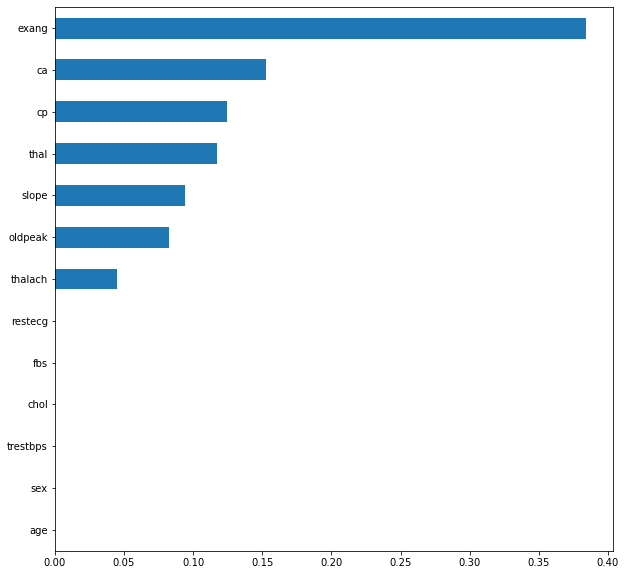

In [5]:
# Get the best estimator's feature importances.
# These tell us which features gave the model the most information as it split.
best_model = grid_tree.best_estimator_
feat_importances = pd.Series(best_model.feature_importances_, index=input_data.columns)
feat_importances.sort_values().plot(kind='barh', figsize=(10,10))

In [6]:
# Multi Metric CV
from sklearn.metrics import accuracy_score, precision_score, recall_score, make_scorer

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'specificity': make_scorer(recall_score,pos_label=0) # Note, this is the double bonus. Not too bad!
}

tuned_parameters = {
    'criterion': ['gini', 'entropy'], # Very hard to say.
    'splitter': ['best', 'random'], # best will be best usually, but sometimes random can surprise you. 
    'max_depth': [None, 5, 10], # None is probably best, allow the tree to grow as much as it needs
    'min_samples_split': [2, 10, 30], # 2 gives the model the most power to overfit, but I think it will win.
    'max_features':[None, 'sqrt', 'log2'], # Hard to say, sqrt and log2 are very similar at this number of columns.
    'max_leaf_nodes': [None, 4, 20], # I suspect 4 will be quite bad, and None will win
    'min_impurity_decrease': [0, 0.01, .05, 0.1] # 0 or .01 will likely be best
}


clf = DecisionTreeClassifier()

# refit=false basically means we aren't choosing one estimator as the "best" one
# We do this because we have multi-metric scoring and it's no longer clear which is "best"
grid_tree = GridSearchCV(clf, tuned_parameters, scoring=scoring, refit=False) 
grid_tree.fit(input_data, labels) 

grid_tree.cv_results_

{'mean_fit_time': array([0.00260091, 0.00205617, 0.00223756, ..., 0.00215011, 0.00214381,
        0.00211282]),
 'std_fit_time': array([0.00029989, 0.00024686, 0.00015577, ..., 0.00038808, 0.00038939,
        0.00043101]),
 'mean_score_time': array([0.00377436, 0.00374961, 0.00383835, ..., 0.00367808, 0.00370936,
        0.00415335]),
 'std_score_time': array([0.00045096, 0.00055029, 0.00069439, ..., 0.00022272, 0.00040231,
        0.00071585]),
 'param_criterion': masked_array(data=['gini', 'gini', 'gini', ..., 'entropy', 'entropy',
                    'entropy'],
              mask=[False, False, False, ..., False, False, False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[None, None, None, ..., 10, 10, 10],
              mask=[False, False, False, ..., False, False, False],
        fill_value='?',
             dtype=object),
 'param_max_features': masked_array(data=[None, None, None, ..., 'log2', 'log2', 'log2'],
              mask=[Fal

In [7]:
# Plus, check out this trick making the DF a bit easier to work with
results = pd.DataFrame({
    'accuracy': grid_tree.cv_results_['mean_test_accuracy'],
    'precision': grid_tree.cv_results_['mean_test_precision'],
    'recall': grid_tree.cv_results_['mean_test_recall'],
    'specificity': grid_tree.cv_results_['mean_test_specificity'],
})

params_df = pd.DataFrame(grid_tree.cv_results_['params'], columns=grid_tree.cv_results_['params'][0].keys())
all_results = pd.concat([results, params_df], axis=1)

# Lots of interesting analysis could be done on this dataframe now to learn
# about the trained models...
all_results

,accuracy,precision,recall,specificity,criterion,max_depth,max_features,max_leaf_nodes,min_impurity_decrease,min_samples_split,splitter
0,0.765410,0.790963,0.787879,0.737302,gini,NaN,None,NaN,0.0,2,best
1,0.749071,0.785271,0.745455,0.752646,gini,NaN,None,NaN,0.0,2,random
2,0.762131,0.788418,0.787879,0.729894,gini,NaN,None,NaN,0.0,10,best
3,0.788689,0.823714,0.787879,0.789418,gini,NaN,None,NaN,0.0,10,random
4,0.795246,0.801993,0.842424,0.737566,gini,NaN,None,NaN,0.0,30,best
...,...,...,...,...,...,...,...,...,...,...,...
1291,0.581257,0.572368,0.987879,0.096296,entropy,10.0,log2,20.0,0.1,2,random
1292,0.729290,0.748648,0.757576,0.696032,entropy,10.0,log2,20.0,0.1,10,best
1293,0.544590,0.544590,1.000000,0.000000,entropy,10.0,log2,20.0,0.1,10,random
1294,0.759071,0.762849,0.824242,0.682275,entropy,10.0,log2,20.0,0.1,30,best


In [8]:
all_results.sort_values('accuracy', ascending=False)

,accuracy,precision,recall,specificity,criterion,max_depth,max_features,max_leaf_nodes,min_impurity_decrease,min_samples_split,splitter
1275,0.815191,0.801310,0.878788,0.739153,entropy,10.0,log2,20.0,0.00,10,random
802,0.811967,0.825153,0.842424,0.774603,entropy,NaN,log2,NaN,0.01,30,best
874,0.811749,0.827331,0.830303,0.789153,entropy,5.0,None,NaN,0.01,30,best
922,0.811749,0.827331,0.830303,0.789153,entropy,5.0,None,20.0,0.01,30,best
916,0.811749,0.827331,0.830303,0.789153,entropy,5.0,None,20.0,0.00,30,best
...,...,...,...,...,...,...,...,...,...,...,...
91,0.544590,0.544590,1.000000,0.000000,gini,NaN,sqrt,NaN,0.10,2,random
379,0.544590,0.544590,1.000000,0.000000,gini,5.0,log2,NaN,0.10,2,random
213,0.544590,0.544590,1.000000,0.000000,gini,NaN,log2,20.0,0.10,10,random
407,0.544590,0.544590,1.000000,0.000000,gini,5.0,log2,4.0,0.10,30,random


In [9]:
all_results.sort_values('specificity', ascending=False)

,accuracy,precision,recall,specificity,criterion,max_depth,max_features,max_leaf_nodes,min_impurity_decrease,min_samples_split,splitter
661,0.759016,0.853653,0.672727,0.862169,entropy,NaN,None,NaN,0.05,2,random
553,0.772077,0.849650,0.709091,0.846825,gini,10.0,sqrt,20.0,0.00,2,random
1016,0.768689,0.835455,0.715152,0.832540,entropy,5.0,log2,NaN,0.01,10,best
827,0.699508,0.827528,0.600000,0.817725,entropy,NaN,log2,4.0,0.01,30,random
965,0.699454,0.806478,0.606061,0.812434,entropy,5.0,sqrt,4.0,0.00,30,random
...,...,...,...,...,...,...,...,...,...,...,...
191,0.544590,0.544590,1.000000,0.000000,gini,NaN,log2,4.0,0.10,30,random
359,0.544590,0.544590,1.000000,0.000000,gini,5.0,sqrt,20.0,0.10,30,random
311,0.544590,0.544590,1.000000,0.000000,gini,5.0,sqrt,NaN,0.10,30,random
619,0.544590,0.544590,1.000000,0.000000,gini,10.0,log2,4.0,0.10,2,random


In [10]:
all_results.sort_values('recall', ascending=False)

,accuracy,precision,recall,specificity,criterion,max_depth,max_features,max_leaf_nodes,min_impurity_decrease,min_samples_split,splitter
213,0.544590,0.544590,1.000000,0.000000,gini,NaN,log2,20.0,0.10,10,random
311,0.544590,0.544590,1.000000,0.000000,gini,5.0,sqrt,NaN,0.10,30,random
1293,0.544590,0.544590,1.000000,0.000000,entropy,10.0,log2,20.0,0.10,10,random
95,0.544590,0.544590,1.000000,0.000000,gini,NaN,sqrt,NaN,0.10,30,random
379,0.544590,0.544590,1.000000,0.000000,gini,5.0,log2,NaN,0.10,2,random
...,...,...,...,...,...,...,...,...,...,...,...
169,0.660546,0.710589,0.630303,0.694974,gini,NaN,log2,4.0,0.00,2,random
1181,0.646940,0.711773,0.618182,0.681217,entropy,10.0,sqrt,4.0,0.00,30,random
585,0.643880,0.753917,0.612121,0.684127,gini,10.0,log2,NaN,0.01,10,random
965,0.699454,0.806478,0.606061,0.812434,entropy,5.0,sqrt,4.0,0.00,30,random


In [11]:
all_results.sort_values('precision', ascending=False)

,accuracy,precision,recall,specificity,criterion,max_depth,max_features,max_leaf_nodes,min_impurity_decrease,min_samples_split,splitter
661,0.759016,0.853653,0.672727,0.862169,entropy,NaN,None,NaN,0.05,2,random
553,0.772077,0.849650,0.709091,0.846825,gini,10.0,sqrt,20.0,0.00,2,random
1154,0.791967,0.839605,0.781818,0.803704,entropy,10.0,sqrt,NaN,0.00,10,best
437,0.798525,0.837155,0.787879,0.811376,gini,10.0,None,NaN,0.00,30,random
1016,0.768689,0.835455,0.715152,0.832540,entropy,5.0,log2,NaN,0.01,10,best
...,...,...,...,...,...,...,...,...,...,...,...
619,0.544590,0.544590,1.000000,0.000000,gini,10.0,log2,4.0,0.10,2,random
359,0.544590,0.544590,1.000000,0.000000,gini,5.0,sqrt,20.0,0.10,30,random
1293,0.544590,0.544590,1.000000,0.000000,entropy,10.0,log2,20.0,0.10,10,random
379,0.544590,0.544590,1.000000,0.000000,gini,5.0,log2,NaN,0.10,2,random


# Part 2, Random Forests

The only new hyperparamters are:

**n_estimators** 

> the number of trees to build. More is "better" but you'll hit a point of diminishing returns as bagging and feature selection can only create so much variance. 

**bootstrap** 

> Whether or not to use bagging. Generally you want this, otherwise your only source of variance is feature selection. 

**oob_score**

> When bagging, you can use "out of bag" samples as a form of validation data, rather than splitting out a validation set explicitly. If your number of estimators is fairly high, you may not have many out of bag samples. We're using a validation set anyway, so we won't use this.

**n_jobs**

> Speed impacting only, we can build these trees in parallel and this value controls how many processes to spin up in that parallel creation process.

**warm_start**

> Only relevant for retraining an existing random forest — warm start can be used to add new estimators when calling .fit more than once on the same model. We won't use this either.

Also note splitter is no longer available, best is always used for RFs.

In [12]:
from sklearn.ensemble import RandomForestClassifier

# Load the data
heart_dataset = pd.read_csv('../datasets/uci-heart-disease/heart.csv')

# Split the data into input and labels
labels = heart_dataset['target']
input_data = heart_dataset.drop(columns=['target'])

# Note, we don't split the data. GridSearchCV will automatically apply 5-fold cross validation by default.


# Note, leaving out class_weights because our data is pretty balanced. 
tuned_parameters = {
    'n_estimators': [10, 50, 100, 200], # 10 is too few, I guess 200 not tons better than 100
    'bootstrap': [True, False], # I guess false will generally perform worse
    'n_jobs': [-1],  # always using max number of jobs
    'criterion': ['gini', 'entropy'], # Not sure what will win out here TBH. Maybe gini.
    'max_depth': [None, 5, 10], # None is probably best, allow the tree to grow as much as it needs
    'min_samples_split': [2, 10, 30], # 2 gives the model the most power to overfit, but I think it will win.
    'max_features':['sqrt', 'log2'], # Quite similar overall.
    'max_leaf_nodes': [None, 4, 20], # I suspect 4 will be quite bad, and None will win
}

# Doing the scoring bonus.
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'specificity': make_scorer(recall_score,pos_label=0) # Note, this is the double bonus. Not too bad!
}

# These two lines will result in every possible combo of the above paramters to be fit and scored
# which can take a LONG TIME with large datasets.
clf = RandomForestClassifier()
grid_tree = GridSearchCV(clf, tuned_parameters, scoring=scoring, n_jobs=-1, refit=False)
grid_tree.fit(input_data, labels) 

GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 5, 10],
                         'max_features': ['sqrt', 'log2'],
                         'max_leaf_nodes': [None, 4, 20],
                         'min_samples_split': [2, 10, 30],
                         'n_estimators': [10, 50, 100, 200], 'n_jobs': [-1]},
             refit=False,
             scoring={'accuracy': make_scorer(accuracy_score),
                      'precision': make_scorer(precision_score),
                      'recall': make_scorer(recall_score),
                      'specificity': make_scorer(recall_score, pos_label=0)})

In [13]:
# Plus, check out this trick making the DF a bit easier to work with
results = pd.DataFrame({
    'accuracy': grid_tree.cv_results_['mean_test_accuracy'],
    'precision': grid_tree.cv_results_['mean_test_precision'],
    'recall': grid_tree.cv_results_['mean_test_recall'],
    'specificity': grid_tree.cv_results_['mean_test_specificity'],
})

params_df = pd.DataFrame(grid_tree.cv_results_['params'], columns=grid_tree.cv_results_['params'][0].keys())
all_results = pd.concat([results, params_df], axis=1)

# Lots of interesting analysis could be done on this dataframe now to learn
# about the trained models...
all_results

,accuracy,precision,recall,specificity,bootstrap,criterion,max_depth,max_features,max_leaf_nodes,min_samples_split,n_estimators,n_jobs
0,0.808306,0.829236,0.830303,0.780688,True,gini,NaN,sqrt,NaN,2,10,-1
1,0.798634,0.819811,0.812121,0.782011,True,gini,NaN,sqrt,NaN,2,50,-1
2,0.828197,0.834295,0.860606,0.788889,True,gini,NaN,sqrt,NaN,2,100,-1
3,0.814863,0.822782,0.848485,0.774339,True,gini,NaN,sqrt,NaN,2,200,-1
4,0.801694,0.812794,0.830303,0.768254,True,gini,NaN,sqrt,NaN,10,10,-1
...,...,...,...,...,...,...,...,...,...,...,...,...
859,0.821585,0.825481,0.860606,0.774339,False,entropy,10.0,log2,20.0,10,200,-1
860,0.821639,0.819351,0.866667,0.767460,False,entropy,10.0,log2,20.0,30,10,-1
861,0.834645,0.823872,0.890909,0.766931,False,entropy,10.0,log2,20.0,30,50,-1
862,0.828306,0.825904,0.872727,0.774868,False,entropy,10.0,log2,20.0,30,100,-1


In [14]:
all_results.sort_values('accuracy', ascending=False)

,accuracy,precision,recall,specificity,bootstrap,criterion,max_depth,max_features,max_leaf_nodes,min_samples_split,n_estimators,n_jobs
201,0.854699,0.836523,0.915152,0.782011,True,gini,10.0,log2,4.0,30,50,-1
166,0.854699,0.834184,0.921212,0.774868,True,gini,10.0,sqrt,4.0,30,100,-1
87,0.851366,0.829176,0.921212,0.767460,True,gini,5.0,sqrt,4.0,2,200,-1
10,0.851366,0.834946,0.909091,0.782011,True,gini,NaN,sqrt,NaN,30,100,-1
155,0.851366,0.835626,0.909091,0.781746,True,gini,10.0,sqrt,NaN,30,200,-1
...,...,...,...,...,...,...,...,...,...,...,...,...
616,0.785027,0.786908,0.842424,0.715344,False,gini,10.0,log2,NaN,10,10,-1
408,0.782077,0.768736,0.860606,0.687831,True,entropy,10.0,log2,4.0,2,10,-1
708,0.781967,0.783070,0.836364,0.716402,False,entropy,NaN,log2,20.0,2,10,-1
580,0.781803,0.782706,0.842424,0.708466,False,gini,10.0,sqrt,NaN,10,10,-1


In [15]:
all_results.sort_values('recall', ascending=False)

,accuracy,precision,recall,specificity,bootstrap,criterion,max_depth,max_features,max_leaf_nodes,min_samples_split,n_estimators,n_jobs
125,0.847978,0.812011,0.939394,0.738624,True,gini,5.0,log2,4.0,10,50,-1
702,0.841475,0.807436,0.933333,0.731217,False,entropy,NaN,log2,4.0,10,100,-1
230,0.848087,0.817314,0.933333,0.746032,True,entropy,NaN,sqrt,4.0,2,100,-1
122,0.848087,0.820085,0.927273,0.753175,True,gini,5.0,log2,4.0,2,100,-1
740,0.828251,0.793722,0.927273,0.709788,False,entropy,5.0,sqrt,4.0,30,10,-1
...,...,...,...,...,...,...,...,...,...,...,...,...
216,0.791803,0.826443,0.787879,0.796296,True,entropy,NaN,sqrt,NaN,2,10,-1
220,0.788743,0.820496,0.787879,0.789947,True,entropy,NaN,sqrt,NaN,10,10,-1
36,0.785410,0.819131,0.787879,0.782011,True,gini,NaN,log2,NaN,2,10,-1
432,0.768743,0.795423,0.781818,0.752910,False,gini,NaN,sqrt,NaN,2,10,-1


In [16]:
all_results.sort_values('specificity', ascending=False)

,accuracy,precision,recall,specificity,bootstrap,criterion,max_depth,max_features,max_leaf_nodes,min_samples_split,n_estimators,n_jobs
364,0.834863,0.871106,0.824242,0.846825,True,entropy,10.0,sqrt,NaN,10,10,-1
692,0.834809,0.852232,0.848485,0.817989,False,entropy,NaN,log2,NaN,30,10,-1
612,0.815082,0.845425,0.818182,0.810847,False,gini,10.0,log2,NaN,2,10,-1
684,0.804973,0.837235,0.800000,0.810847,False,entropy,NaN,log2,NaN,2,10,-1
396,0.811803,0.845673,0.812121,0.810582,True,entropy,10.0,log2,NaN,2,10,-1
...,...,...,...,...,...,...,...,...,...,...,...,...
196,0.791967,0.771145,0.878788,0.688095,True,gini,10.0,log2,4.0,10,10,-1
408,0.782077,0.768736,0.860606,0.687831,True,entropy,10.0,log2,4.0,2,10,-1
416,0.795027,0.772889,0.884848,0.687566,True,entropy,10.0,log2,4.0,30,10,-1
140,0.792022,0.769217,0.884848,0.680952,True,gini,5.0,log2,20.0,30,10,-1


In [17]:
all_results.sort_values('precision', ascending=False)

,accuracy,precision,recall,specificity,bootstrap,criterion,max_depth,max_features,max_leaf_nodes,min_samples_split,n_estimators,n_jobs
364,0.834863,0.871106,0.824242,0.846825,True,entropy,10.0,sqrt,NaN,10,10,-1
692,0.834809,0.852232,0.848485,0.817989,False,entropy,NaN,log2,NaN,30,10,-1
713,0.847978,0.849352,0.884848,0.803439,False,entropy,NaN,log2,20.0,10,50,-1
209,0.844645,0.847157,0.878788,0.803175,True,gini,10.0,log2,20.0,10,50,-1
857,0.838142,0.846974,0.866667,0.803439,False,entropy,10.0,log2,20.0,10,50,-1
...,...,...,...,...,...,...,...,...,...,...,...,...
416,0.795027,0.772889,0.884848,0.687566,True,entropy,10.0,log2,4.0,30,10,-1
196,0.791967,0.771145,0.878788,0.688095,True,gini,10.0,log2,4.0,10,10,-1
300,0.788525,0.769998,0.878788,0.680159,True,entropy,5.0,sqrt,4.0,2,10,-1
140,0.792022,0.769217,0.884848,0.680952,True,gini,5.0,log2,20.0,30,10,-1


### Any Patterns?

`n_estimators = 10` appears in several best performers (but nearly all the worst performers...). In part this is due to the small size/complexity of the dataset. `n_estimators=200` is not common in either of the best/worst, indicating that we don't appear to gain that much from going super big (again, in part due to the small/simple dataset)

Interesting that `max_leaf_nodes = 4` is common in top performing accuracy and recall. This isn't too surprisng, as ensembling often works well when we combine many "weak learners."

The tradeoff between specificity and recall is really pronounced, the best and worst performers are almost inverse of each other for those metrics!


### Note, part 2 bonuses:

The code changes are identical for part 2 and part 1, so refer to part 1 for the answers. 

## Part 3: Comparing Results

Write a few paragraphs summarizing the differences you've found with this dataset and these two types of model. While writing, consider the following:

* Is one of these two model types better "on average"?
    * **the best RFs are better than the best DTs**
* Consider the best and worse performing models of each type:
    * Are the worst performing models similarly bad, or is one much better?
      * **No, the worst performing DTs are much worse than the worst RFs**
    * What about the best performing, are they similarly good or is one much better?
      * **The best RFs are slightly better than the best DTs**
* Compare the training times for each type.
    * Was one much faster than the other?
        * **RF is much more expensive to train**
    * Which hyperparameters could a major impact on time to train?
        * **n_estimators, n_jobs, n_features are all big ones for training times**
    * Imagine your dataset became much larger, could the time-to-train become a serious problem?
        * **absolutely**